In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Flatten
from keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
from keras import backend as K
from mpl_toolkits.mplot3d import Axes3D
import math
import json
from io import StringIO
from keras.utils.generic_utils import serialize_keras_object
import datetime
import tensorflow_probability as tfp
import seaborn as sns

Using TensorFlow backend.


In [2]:
tf.version.VERSION

'2.4.1'

In [3]:
seed  = 1
tf.random.set_seed(seed)
np.random.seed(seed+1)

# Tools

In [111]:
def z_score(df,i):
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns[i:]:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
    return df_std

def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    #return 1-K.square(r)?
    return r

def correl(y_true, y_pred):
    corr = tfp.stats.correlation(y_true, y_pred, sample_axis=0, event_axis=None)
    return corr

def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

# Positional Encoding

In [112]:
#Positional Encoding
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
  return K.cast(pos_encoding, dtype=tf.float32)  
  #return tf.cast(pos_encoding, dtype=tf.float32)

In [113]:
class Linear(keras.layers.Layer):
    def __init__(self, units, input_dim):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'weights': self.w,
            'bias': self.b,
        })
        return config

# Model

# Encoder

In [133]:
# Hyperparameters
d_model = 24
dff=32
maximum_position_encoding = 10000
# Size of input vocab plus start and end tokens
input_vocab_size = 20
target_vocab_size = 3

In [134]:
# Encoder
input = tf.keras.layers.Input(shape=(None,))
linear_layer = Linear(d_model, input_vocab_size)
x = linear_layer(input)
x=tf.reshape(x,[-1,1,d_model])

In [135]:
# positional encoding
scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

In [136]:
## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)
x = tf.keras.layers.Add()([x , attention]) # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

In [137]:
## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])     # residual connection
encoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Decoder

In [138]:
# Decoder
target = tf.keras.layers.Input(shape=(None,))
linear_layer = Linear(d_model, target_vocab_size)
x=linear_layer(target)
x=tf.reshape(x,[-1,1,d_model])

In [139]:
## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :] ])           

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention(causal = True)([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)
x = tf.keras.layers.Add()([x , attention])  # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

In [140]:
## encoder-decoder attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(encoder)
key = tf.keras.layers.Dense(d_model)(encoder)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)
x = tf.keras.layers.Add()([x , attention])  # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)


In [141]:
## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])      # residual connection
decoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

In [142]:
x = tf.keras.layers.Dense(1)(decoder)
base_model = tf.keras.models.Model(inputs=[input,target], outputs=x)
sgd = tf.keras.optimizers.SGD(lr = 0.05)
base_model.compile(loss='mse', optimizer=sgd,metrics=[correlation_coefficient])

In [143]:
base_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
linear_14 (Linear)              (None, 24)           504         input_15[0][0]                   
__________________________________________________________________________________________________
tf.reshape_14 (TFOpLambda)      (None, 1, 24)        0           linear_14[0][0]                  
__________________________________________________________________________________________________
multiply_14 (Multiply)          (None, 1, 24)        0           tf.reshape_14[0][0]              
____________________________________________________________________________________________

In [144]:
x

<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'dense_136')>

# DataSets

In [154]:
Myfile=r'C:\Users\fahd1\Excels\ETF_Risk_Factors.xlsx'
MyData=pd.read_excel(Myfile, sheet_name="Risk_Factors")
MyData.columns

Index(['Date', 'WeekDay', 'Unit', 'Ticker', 'Sector', 'Return', 'Momentum',
       'Volatility', 'RSI', 'Mean_Reversion'],
      dtype='object')

In [159]:
l=Remove(MyData['Ticker'])

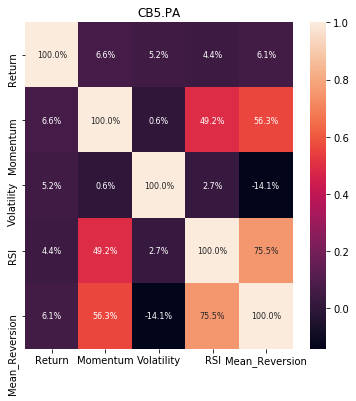

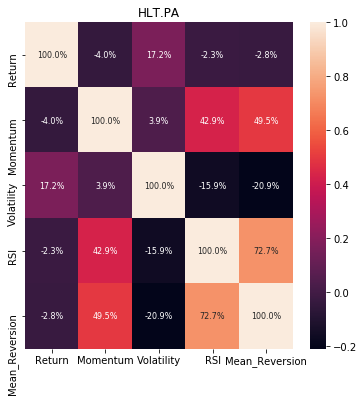

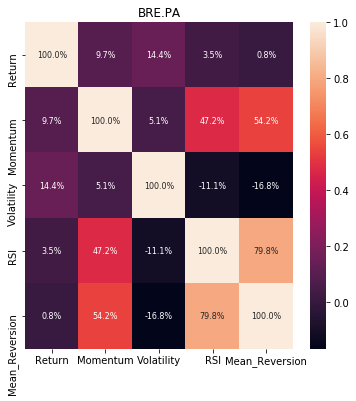

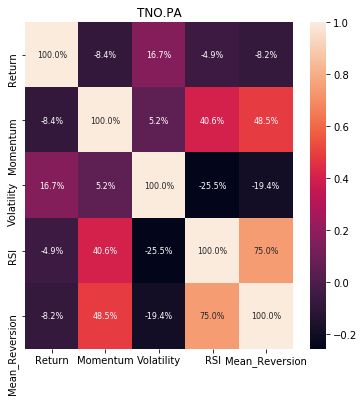

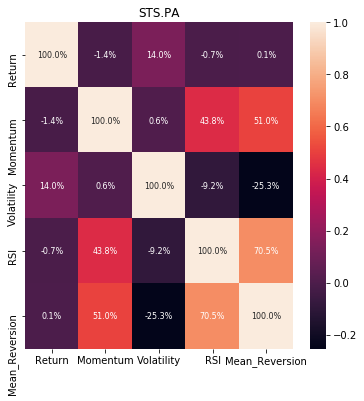

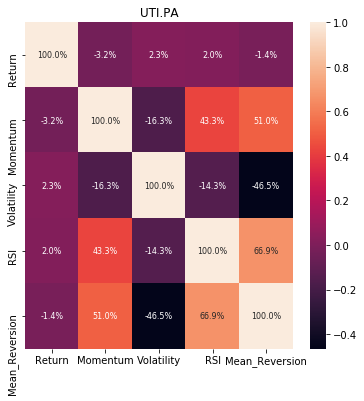

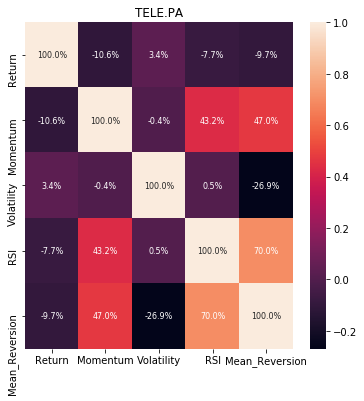

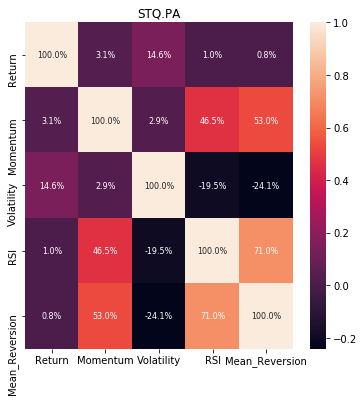

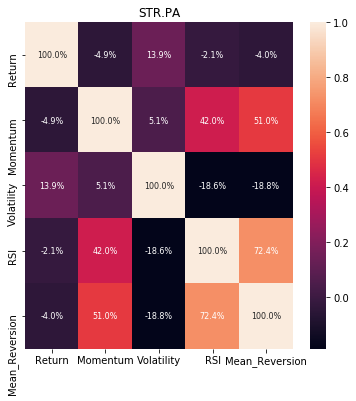

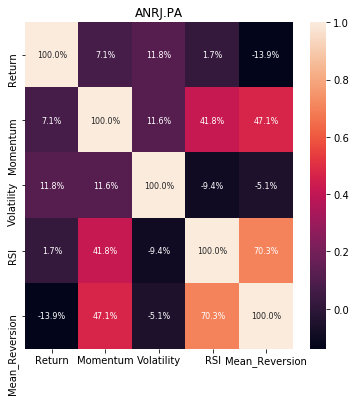

In [161]:
for elem in l:
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(MyData[MyData['Ticker']==elem][MyData.columns[5:]].corr(), annot = True,fmt=".1%",annot_kws={"size": 8},ax=ax)
    plt.title(elem)
    plt.show()

In [147]:
l=Remove(MyData['Date'])
Start_Date=min(l)
End_Date=max(l)
date1 = Start_Date + datetime.timedelta(days=200)
date2= date1 + datetime.timedelta(days=5)
date3= date2 + datetime.timedelta(days=1)
(Start_Date,date1,date2,date3,End_Date)

(Timestamp('2016-01-11 00:00:00'),
 Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-03 00:00:00'),
 Timestamp('2016-08-04 00:00:00'),
 Timestamp('2021-01-08 00:00:00'))

In [148]:
u1=50
u2=51
u3=52
l=min(Remove(MyData[MyData['Unit']==u1]['Date']))
l

Timestamp('2016-09-27 00:00:00')

In [149]:
#d=MyData[(MyData['Date']<=date1)]['WeekDay']
x_Train=MyData[(MyData['Unit']<=u1)][MyData.columns[5:]]
x_Train=z_score(x_Train,0)
y_Train=MyData[(MyData['Unit']<=u1)][MyData.columns[4]]

x_Test = MyData[(MyData['Unit']>=u2)&(MyData['Unit']<u3)][MyData.columns[5:]]
x_Test=z_score(x_Test,0)
y_Test=MyData[(MyData['Unit']>=u2)&(MyData['Unit']<u3)][MyData.columns[4]]

x_Train=np.asarray(x_Train).astype('float32')
y_Train=np.asarray(y_Train).astype('float32')
x_Test=np.asarray(x_Test).astype('float32')
y_Test=np.asarray(y_Test).astype('float32')


x_Train=x_Train.reshape(-1,20)
y_Train=y_Train.reshape(-1,4)
x_Test=x_Test.reshape(-1,20)
y_Test=y_Test.reshape(-1,4)

In [150]:
(x_Train.shape,y_Train.shape,x_Test.shape,y_Test.shape)

((5850, 20), (5850, 4), (117, 20), (117, 4))

# Train Model

In [128]:
base_model.fit(x = [x_Train, y_Train[:, :-1]], y = y_Train[:, 1:],
               batch_size=64,epochs=150,validation_data=([x_Test, y_Test[:, :-1]], y_Test[:, 1:]))

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

KeyboardInterrupt: 

# Prediction

In [70]:
y=base_model.predict([x_Test,y_Test[:, :-1]])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [130]:
y=y.reshape(x_Test.shape[0])
x=y_Test[:,3]

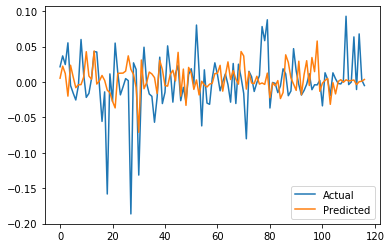

In [131]:
plt.plot(x, label='Actual')
plt.plot(y, label='Predicted')
plt.legend()
plt.show()

In [132]:
np.corrcoef(x,y)

array([[1.        , 0.12558532],
       [0.12558532, 1.        ]])

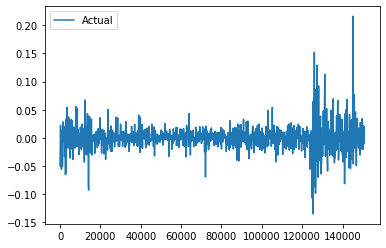

In [153]:
x=MyData[MyData['Ticker']=='AC.PA']['Return1d']
plt.plot(x, label='Actual')
plt.legend()
plt.show()